In [3]:
# Climate_env
# Import Packages
import xarray as xr
import pandas as pn
import numpy as np
import pandas as pd
import subprocess as sb
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm

In [5]:
!ls ../Data/*.grib

../Data/UERRA_Volumetric_Soil_moisture.grib


# Export info. to the text file

In [ ]:
!cdo griddes UERRA_Volumetric_Soil_moisture.grib > grid_info.txt

# Remap and clip to the Latlon Coordinate using CDO

 5 and 30 arc-minute grids as 10km and 50km grids

In [7]:
### How to calculate the targetgrid file

# Xfirst, yfirst > the left down corner coordinates 
# Xsize,Ysize > the number of the pixels
# Xinc,Yinc > the pixel size
# Xsecond,Ysecond > the right upper corner coordinates

# xsize= (xsecond - xfirst)/xinc
# ysize= (ysecond - yfirst)/yinc

In [ ]:
!cdo -f nc remapbil,outgrid.txt -shifttime,2hour UERRA_Volumetric_Soil_moisture.grib  UERRA_Volumetric_Soil_moisture_clip.nc

## Clipping using xarray

In [ ]:
# Cliping the intrest area
clip_sm_allPeriod = sm_2010_2018.vsw.sel(latitude=slice(41.5, 38.5),longitude=slice(8,10))

In [7]:
clip_sm_allPeriod

<xarray.DataArray 'sm' (time: 3103, lat: 12, lon: 8)>
dask.array<shape=(3103, 12, 8), dtype=float32, chunksize=(1, 12, 8)>
Coordinates:
  * lat      (lat) float32 41.375 41.125 40.875 40.625 ... 39.125 38.875 38.625
  * lon      (lon) float32 8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2018-06-30
Attributes:
    long_name:        Volumetric Soil Moisture
    units:            m3 m-3
    valid_range:      [0. 1.]
    _CoordinateAxes:  time lat lon

In [9]:
clip_sm_allPeriod.to_netcdf(path='../Data/result/clip_sm_allPeriod.nc',format = 'NETCDF4')

## Visulization the clipped image

In [9]:
!ls ../Data/*.nc

../Data/UERRA_Volumetric_Soil_moisture_clip.nc


In [10]:
sm_2010_2018 = xr.open_mfdataset('../Data/UERRA_Volumetric_Soil_moisture_clip.nc')

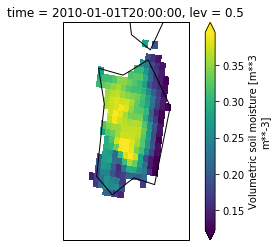

In [12]:
# Centered over Darmstadt
ax = plt.axes(projection=ccrs.Orthographic(20, 50))
ax.coastlines()
# Use last time step in array.
p = sm_2010_2018.vsw.isel(time=3).plot(transform=ccrs.PlateCarree(), robust=True)

## Bi-weekly Aggregation

In [ ]:
# multi-year daily mean calculated

!cdo ydaymean  UERRA_Volumetric_Soil_moisture_clip.nc UERRA_Volumetric_Soil_multiYear_daily_mean.nc


# bi-weely mean was calculated based on the daily mean

!cdo timselmean,14 UERRA_Volumetric_Soil_multiYear_daily_mean.nc UERRA_Volumetric_Soil_biWeekly_mean.nc



#### Selection of the timestamps (May - Oct.) ~ 12 weeks

In [13]:
a = xr.open_dataset('../Data/Result/UERRA_Volumetric_Soil_biWeekly_mean.nc')

In [14]:
sel_a = a.sel(time=slice('2018-05-01', '2018-10-31'))

In [15]:
sel_a.to_netcdf(path='../Data/result/sel_period_biweekly.nc',format = 'NETCDF4')

In [ ]:

# The bi-weekly data was separated into different layer for further analysis

!cdo splitsel,1 sel_period_biweekly.nc bi_weekly_

## Yearly Agrregation

In [ ]:
# Yearly mean

!cdo yearmean UERRA_Volumetric_Soil_moisture_clip.nc UERRA_Volumetric_Soil_moisture_yearly_mean.nc

In [ ]:
! cdo outputtab,date,value,name UERRA_Volumetric_Soil_moisture_yearly_mean.nc>yearly.txt

In [ ]:
# The yearly data was separated into different layer for further analysis

!cdo splitsel,1 clip_sm_allPeriod_yearly_mean.nc yearly

## Visulization Yearly Aggregation

In [13]:
!ls ../Data/Result/*.nc

../Data/Result/UERRA_Volumetric_Soil_biWeekly_mean.nc
../Data/Result/UERRA_Volumetric_Soil_moisture_yearly_mean.nc
../Data/Result/UERRA_Volumetric_Soil_multiYear_daily_mean.nc


In [14]:
yearly_mean = xr.open_dataset('../Data/Result/UERRA_Volumetric_Soil_moisture_yearly_mean.nc')

In [21]:
yearly_mean

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 28, lev: 1, lon: 18, time: 9)
Coordinates:
  * time       (time) datetime64[ns] 2010-07-02T11:00:00 ... 2018-07-02T11:00:00
  * lon        (lon) float32 8.0 8.11 8.22 8.33 8.44 ... 9.54 9.65 9.76 9.87
  * lat        (lat) float32 38.5 38.61 38.72 38.83 ... 41.14 41.25 41.36 41.47
  * lev        (lev) float64 0.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lev_bnds   (lev, bnds) float64 ...
    vsw        (time, lev, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Sat Jun 22 11:06:05 2019: cdo yearmean UERRA_Volumetric_Soi...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.90it/s]


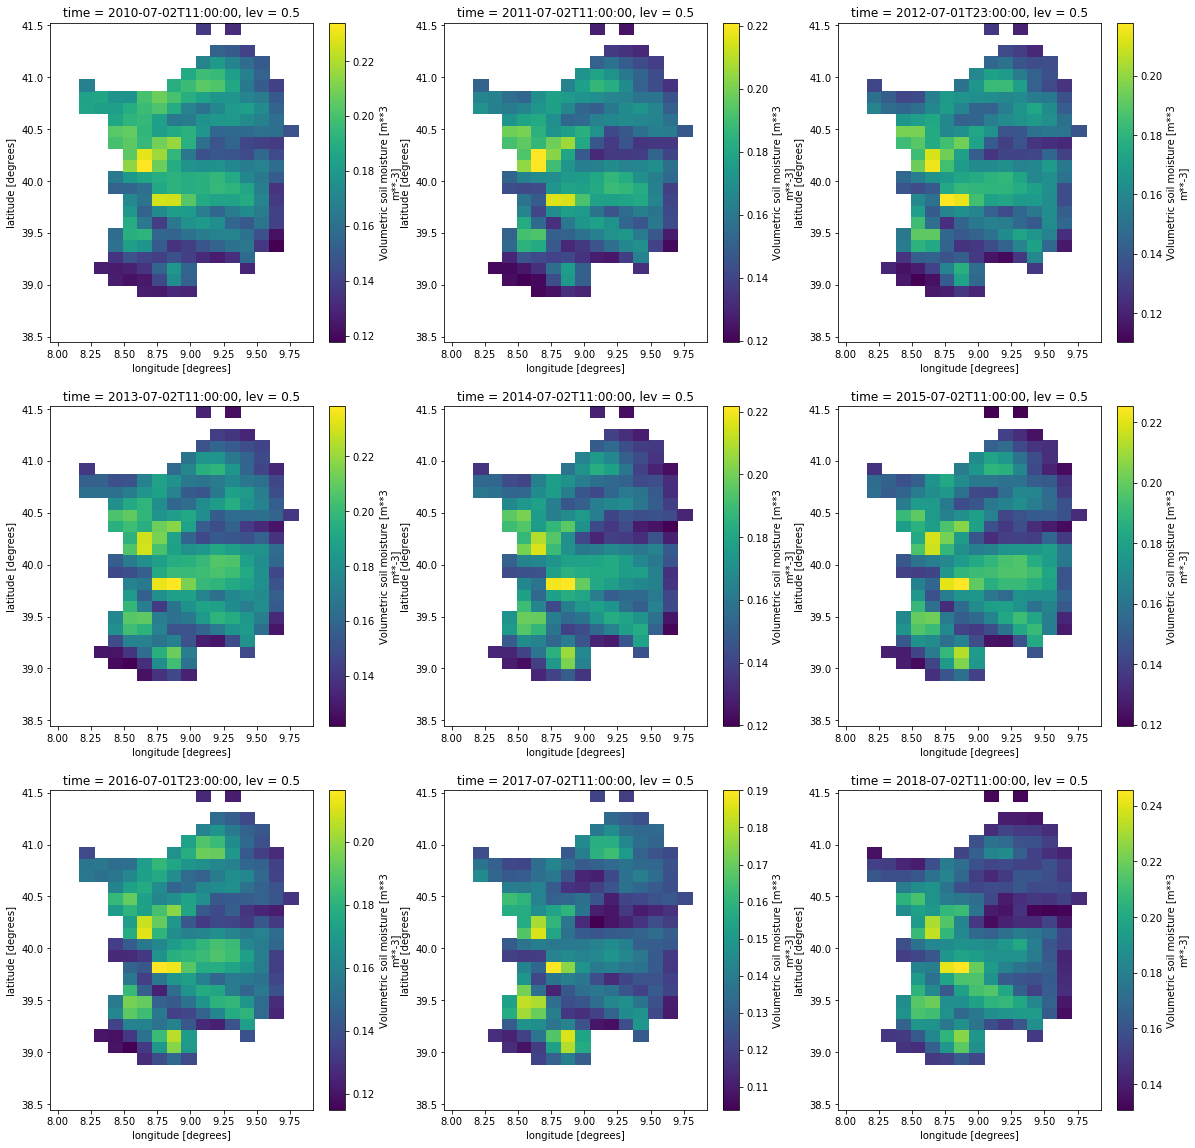

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
for i in tqdm(range(0, 3)):
    for j in range(0, 3):
        year = ((i * 3) + j)
        yearly_mean.vsw.isel(time=year,lev=0).plot.pcolormesh(ax=axes[i,j])

# Build NetCDF from CSV file (Fire DATA)

In [2]:
!ls ../Data/Result/Fire_data/*.csv

../Data/Result/Fire_data/fire_points.csv


In [5]:
df = pd.read_csv("../Data/Result/Fire_data/fire_points.csv",sep=';')

In [5]:
df.head()

,id,area_ha,province,lon,lat
0,1,32,Cagliari,9.067254,39.382330
1,2,49,Medio Campidano,9.005168,39.478324
2,3,2108,Nuoro,8.623332,40.279205
3,4,3259,Nuoro,8.709084,40.299548
4,5,324,Nuoro,8.851534,40.290140


## Classification of fires

### Area of the fire

In [297]:
(df['area_ha'].max() - df['area_ha'].min())/3

1677.0

In [298]:
#def fire_level(x):
#    if x <= 1677:
#        return 1
#    elif x>1677 and x<= 2200:
#        return 2
#    else:
#        return 3
#df['fire_level'] = df['area_ha'].apply(fire_level)

### Repetition on the area

In [6]:
df['repetition'] = 1

In [7]:
df.head()

,id,area_ha,province,lon,lat,repetition
0,1,32,Cagliari,9.067254,39.382330,1
1,2,49,Medio Campidano,9.005168,39.478324,1
2,3,2108,Nuoro,8.623332,40.279205,1
3,4,3259,Nuoro,8.709084,40.299548,1
4,5,324,Nuoro,8.851534,40.290140,1


# Ceartion of the NetCDF file for fire data

In [8]:
!ls ../Data/Result/*.nc

../Data/Result/clip_sm_allPeriod.nc
../Data/Result/clip_sm_allPeriod_biWeekly_mean.nc
../Data/Result/clip_sm_allPeriod_multiYear_daily_mean.nc
../Data/Result/clip_sm_allPeriod_yearly_mean.nc


In [9]:
sm_yearly_mean= xr.open_dataset("../Data/Result/clip_sm_allPeriod_yearly_mean.nc")

In [10]:
sm_yearly_mean

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 12, lon: 8, time: 9)
Coordinates:
  * time       (time) datetime64[ns] 2010-07-02 2011-07-02 ... 2018-04-01
  * lon        (lon) float32 8.125 8.375 8.625 8.875 9.125 9.375 9.625 9.875
  * lat        (lat) float32 41.375 41.125 40.875 ... 39.125 38.875 38.625
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sm         (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Wed Jun 05 10:41:58 2019: cdo yearmean clip_sm_allPeriod.nc...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [11]:
lon = sm_yearly_mean.sm.lon.values
lat = sm_yearly_mean.sm.lat.values

In [12]:
lat

array([41.375, 41.125, 40.875, 40.625, 40.375, 40.125, 39.875, 39.625,
       39.375, 39.125, 38.875, 38.625], dtype=float32)

In [13]:
delta_lon = lon[1] - lon[0]
delta_lat = lat[1] - lat[0]

In [21]:
llat = lat.min()
ulat = lat.max()
llon = lon.min()
ulon = lon.max()
(llon, llat, ulon, ulat)

(8.125, 38.625, 9.875, 41.375)

In [22]:
grid = np.zeros((lon.shape[0], lat.shape[0]))

In [23]:
df["i"] = df["lon"].apply(lambda x: int(round((x - llon) / delta_lon)))
df["j"] = df["lat"].apply(lambda y: int((round((y - llat) / delta_lat))-1))

In [17]:
df.dropna(inplace=True)

In [37]:
row

id                     113
area_ha                365
province      Olbia-Tempio
lon                9.67861
lat                40.7358
repetition               1
i                        6
j                       -9
Name: 112, dtype: object

In [27]:
rows = lat.shape[0]
columns = lon.shape[0]
size = (rows, columns)

fire = np.zeros(size)
fire_count = np.zeros(size)


for idx, row in df.iterrows():
    i = row.i
    j = row.j
    fire[j][i] += float(row.repetition)
    fire_count[j][i] += 1
    
#fire = np.add(fire, fire_count, out=np.zeros_like(fire), where=fire_count!=0)

In [19]:
dlon = xr.DataArray(lon, dims=['longitude'])
dlat = xr.DataArray(lat, dims=['latitude'])

In [20]:
ds_fire = xr.Dataset(
    data_vars = {'fire_level': (('latitude', 'longitude'), fire)},
    coords = {'latitude': lat,
             'longitude': lon}
)

In [21]:
ds_fire

<xarray.Dataset>
Dimensions:     (latitude: 12, longitude: 8)
Coordinates:
  * latitude    (latitude) float32 41.375 41.125 40.875 ... 39.125 38.875 38.625
  * longitude   (longitude) float32 8.125 8.375 8.625 ... 9.375 9.625 9.875
Data variables:
    fire_level  (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

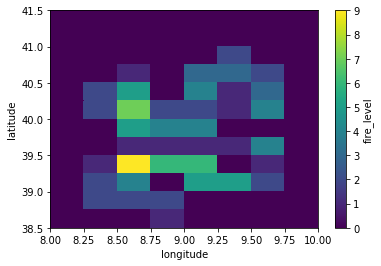

In [22]:
ds_fire.fire_level.plot()

In [23]:
ds_fire.to_netcdf('../Data/Result/fire_repetition.nc')

In [ ]:
!cdo griddes data/mescan-surfex/precipitation/mescan-surfex-precipitation-2014.grib > grid_precipitation.txt

In [5]:
a = xr.open_dataset('../Data/Result/test_resample.nc')

In [6]:
a

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 12, lon: 8, time: 25)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-08 ... 2017-12-28T12:00:00
  * lon        (lon) float32 8.125 8.1255 8.126 8.1265 8.127 8.1275 8.128 8.1285
  * lat        (lat) float32 41.375 41.3745 41.374 ... 41.3705 41.37 41.3695
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sm         (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history:      Sat Jun 15 11:20:14 2019: cdo remapbil,resmple_grid.txt cli...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

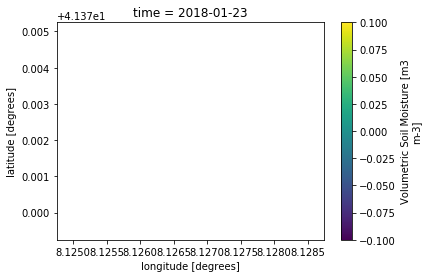

In [9]:
a.sm.isel(time=1).plot()

In [93]:
lons, lats = np.meshgrid(sm_yearly_mean.sm.lon, sm_yearly_mean.sm.lat)

In [119]:
data = {}

In [120]:
data.keys()

dict_keys([])

In [121]:
for m in range(0, 9):
    data["lat"] = lats.ravel()
    data["lon"] = lons.ravel()
    data["sm_%02d" % (m + 2010)] = sm_yearly_mean.sm[m].values.ravel()
    

In [122]:
df = pd.DataFrame(data)

In [125]:
df.head()

,lat,lon,sm_2010,sm_2011,sm_2012,sm_2013,sm_2014,sm_2015,sm_2016,sm_2017,sm_2018
12,41.125,9.125,0.232390,0.197842,0.202369,NaN,NaN,NaN,NaN,NaN,NaN
13,41.125,9.375,0.240188,0.219680,0.266413,NaN,NaN,NaN,NaN,NaN,NaN
19,40.875,8.875,0.222997,0.203450,0.226598,0.235182,0.211713,0.195051,0.212598,0.198100,0.265417
20,40.875,9.125,0.236278,0.211050,0.227311,0.231003,0.213771,0.205365,0.215925,0.220320,0.277636
21,40.875,9.375,0.221529,0.202406,0.226960,0.238107,0.207967,0.199818,0.217201,0.220728,0.276430


In [130]:
df = df[df["sm_2010"] > 0]

In [131]:
df.columns[1:]

Index(['lon', 'sm_2010', 'sm_2011', 'sm_2012', 'sm_2013', 'sm_2014', 'sm_2015',
       'sm_2016', 'sm_2017', 'sm_2018'],
      dtype='object')

In [11]:
# https://gist.github.com/shoyer/0eb96fa8ab683ef078eb

In [12]:
#a =xr.DataArray.to_dataframe(clip_sm)

NameError: name 'clip_sm' is not defined

In [ ]:
#a.groupby('time').mean()

In [ ]:
https://code.mpimet.mpg.de/boards/1/topics/3225
    
    https://code.mpimet.mpg.de/boards/1/topics/2214

In [1]:
!ls *.nc

UERRA_Volumetric_Soil_biWeekly_mean.nc


In [4]:
a = xr.open_dataset('UERRA_Volumetric_Soil_biWeekly_mean.nc')

In [5]:
a.time

<xarray.DataArray 'time' (time: 27)>
array(['2018-01-08T08:00:00.000000000', '2018-01-22T08:00:00.000000000',
       '2018-02-05T08:00:00.000000000', '2018-02-19T08:00:00.000000000',
       '2018-03-04T08:00:00.000000000', '2018-03-18T08:00:00.000000000',
       '2018-04-01T08:00:00.000000000', '2018-04-15T08:00:00.000000000',
       '2018-04-29T08:00:00.000000000', '2018-05-13T08:00:00.000000000',
       '2018-05-27T08:00:00.000000000', '2018-06-10T08:00:00.000000000',
       '2018-06-24T08:00:00.000000000', '2018-07-08T08:00:00.000000000',
       '2018-07-22T08:00:00.000000000', '2018-08-05T08:00:00.000000000',
       '2018-08-19T08:00:00.000000000', '2018-09-02T08:00:00.000000000',
       '2018-09-16T08:00:00.000000000', '2018-09-30T08:00:00.000000000',
       '2018-10-14T08:00:00.000000000', '2018-10-28T08:00:00.000000000',
       '2018-11-11T08:00:00.000000000', '2018-11-25T08:00:00.000000000',
       '2018-12-09T08:00:00.000000000', '2018-12-23T08:00:00.000000000',
       '2018-1

In [12]:
a.sel(time=slice('2018-05-01', '2018-10-31'))

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 28, lev: 1, lon: 18, time: 13)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-13T08:00:00 ... 2018-10-28T08:00:00
  * lon        (lon) float32 8.0 8.11 8.22 8.33 8.44 ... 9.54 9.65 9.76 9.87
  * lat        (lat) float32 38.5 38.61 38.72 38.83 ... 41.14 41.25 41.36 41.47
  * lev        (lev) float64 0.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lev_bnds   (lev, bnds) float64 ...
    vsw        (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Sat Jun 22 11:01:28 2019: cdo timselmean,14 UERRA_Volumetri...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...